In [1]:
import os
import numpy as np
import pandas as pd
from collections import deque

from music21 import converter, instrument, note, chord, bar, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
W0830 11:04:03.748008 15232 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [2]:
K.tensorflow_backend._get_available_gpus()

W0830 11:04:29.789953 15232 module_wrapper.py:137] From c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
midi_directory = "midi/Piano"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
offsets = [[] for track in tracks]
velocities = [[] for track in tracks]
for i, file in enumerate(os.listdir(midi_directory)):
    midi_part = converter.parse(os.path.join(midi_directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        last_offset = 0
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[track].append([str(elem.pitch)])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, chord.Chord):
                notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, note.Rest):
                notes[track].append([elem.name])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(0)
            last_offset = elem.offset
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track, _ in enumerate(tracks)]
#np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(durations[track]))
# Get all offsets
offsets_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    offsets_vocab[track] = sorted(set(offsets[track]))
# Get all velocities
velocities_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    velocities_vocab[track] = sorted(set(velocities[track]))
    
for track, _ in enumerate(tracks):
    print("%s Notes, notes_Vocab : %s ; durations_Vocab : %s ; offsets_vocab : %s ; velocities_vocab : %s" % 
          (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track]), len(offsets_vocab[track]), len(velocities_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)
print(offsets_vocab, offsets)
print(velocities_vocab, velocities)

Song alb_esp1_format0.mid Loaded
Song alb_esp2_format0.mid Loaded
Song alb_esp3_format0.mid Loaded
Song alb_se7_format0.mid Loaded
Song alb_se8_format0.mid Loaded
Song appass_3_format0.mid Loaded
Song bach_846_format0.mid Loaded
Song bach_850_format0.mid Loaded
Song beethoven_hammerklavier_1_format0.mid Loaded
Song beethoven_opus10_1_format0.mid Loaded
Song beethoven_opus10_2_format0.mid Loaded
Song beethoven_opus22_2_format0.mid Loaded
Song beethoven_opus22_3_format0.mid Loaded
Song beethoven_opus22_4_format0.mid Loaded
Song bk_xmas4_format0.mid Loaded
Song bor_ps6_format0.mid Loaded
Song bor_ps7_format0.mid Loaded
Song brahms_opus117_1_format0.mid Loaded
Song brahms_opus1_2_format0.mid Loaded
Song br_im2_format0.mid Loaded
Song br_rhap_format0.mid Loaded
Song burg_perlen_format0.mid Loaded
Song chpn-p10_format0.mid Loaded
Song chpn-p11-format0.mid Loaded
Song chpn-p11_format0.mid Loaded
Song chpn-p24_format0.mid Loaded
Song chpn_op10_e01_format0.mid Loaded
Song chpn_op10_e12_format0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
# Save vocab to file

In [5]:
np.save("vocab_save/full_piano_vocab.npy", np.array([notes_vocab, durations_vocab, offsets_vocab, velocities_vocab]))

In [26]:
# turn notes to integers:

In [35]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
cat_offsets = [[] for track in tracks]
cat_velocities = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
    for elem in offsets[track]:
        int_offset = offsets_vocab[track].index(elem)
        cat = np.zeros((len(offsets_vocab[track])))
        cat[int_offset] = 1
        cat_offsets[track].append(cat)
    for elem in velocities[track]:
        int_velocity = velocities_vocab[track].index(elem)
        cat = np.zeros((len(velocities_vocab[track])))
        cat[int_velocity] = 1
        cat_velocities[track].append(cat)
# merge
x = [cat_notes, cat_durations, cat_offsets, cat_velocities]

In [36]:
print([len(x[0][i]) for i, _ in enumerate(tracks)])

[170354]


In [37]:
# Build generator

In [73]:
seq_len = 32
batch_size = 32
split = int(0.8 * len(x[0][0]))
print(split)

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
        
    def __len__(self):
        return min([len(self.x[0][i]) for i, _ in enumerate(tracks)]) // self.batch_size - 1
    
    def __getitem__(self, idx):
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        X_offset = [[] for track in tracks]
        X_velocity = [[] for track in tracks]
        
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        Y_offset = [[] for track in tracks]
        Y_velocity = [[] for track in tracks]
        
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                
                X_note[track].append(self.x[0][track][idx+i : idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i : idx+i + seq_len])
                X_offset[track].append(self.x[2][track][idx+i : idx+i + seq_len])
                X_velocity[track].append(self.x[3][track][idx+i : idx+i + seq_len])
                
                Y_note[track].append(self.x[0][track][idx+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + seq_len])
                Y_offset[track].append(self.x[2][track][idx+i + seq_len])
                Y_velocity[track].append(self.x[3][track][idx+i + seq_len])
            
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            X_offset[track] = np.array(X_offset[track])
            X_velocity[track] = np.array(X_velocity[track])
            
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            Y_offset[track] = np.array(Y_offset[track])
            Y_velocity[track] = np.array(Y_velocity[track])
            
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[0].append(X_offset[track])
            res[0].append(X_velocity[track])
            
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
            res[1].append(Y_offset[track])
            res[1].append(Y_velocity[track])
            
        return res
    
data_gen = dataGenerator(x, batch_size)
#val_gen = dataGenerator(np.array(x)[:, :, split:], batch_size)

136283


In [74]:
print(data_gen[0][0][0].shape)
#print(val_gen[0][0][0].shape)

(32, 32, 14978)


In [75]:
# Build Model

In [76]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = LSTM(64, return_sequences=True)(in_note)
    x1 = Bidirectional(LSTM(32))(x1)
    x1 = Dropout(0.3)(x1)
    tracks_list.append(x1)
    
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = LSTM(64, return_sequences=True)(in_duration)
    x2 = Bidirectional(LSTM(32))(x2)
    x2 = Dropout(0.3)(x2)
    tracks_list.append(x2)

    in_offset = Input(shape=(seq_len, len(offsets_vocab[track])))
    inputs_list.append(in_offset)
    x3 = LSTM(64, return_sequences=True)(in_offset)
    x3 = Bidirectional(LSTM(32))(x3)
    x3 = Dropout(0.3)(x3)
    tracks_list.append(x3)
    
    in_velocity = Input(shape=(seq_len, len(velocities_vocab[track])))
    inputs_list.append(in_velocity)
    x4 = LSTM(64, return_sequences=True)(in_velocity)
    x4 = Bidirectional(LSTM(32))(x4)
    x4 = Dropout(0.3)(x4)
    tracks_list.append(x4)

concat = Concatenate()(tracks_list)
shared = Dense(64, activation='relu')(concat)
shared = Dense(32, activation='relu')(shared)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)
    
    out_offset = Dense(len(offsets_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_offset)
    
    out_velocity = Dense(len(velocities_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_velocity)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 14978)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 564)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32, 118)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32, 109)      0                                            
____________________________________________________________________________________________

In [77]:
#save best model if model improved
model_name = "Piano_100.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("weight_save", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [78]:
h = model.fit_generator(data_gen, epochs = 10, callbacks=[best_checkpoint])

Epoch 1/10
5322/5322 [==============================] - 2953s 555ms/step - loss: 9.2931 - dense_3_loss: 4.0147 - dense_4_loss: 1.1199 - dense_5_loss: 1.0876 - dense_6_loss: 3.0709 - dense_3_acc: 0.1206 - dense_4_acc: 0.6611 - dense_5_acc: 0.6293 - dense_6_acc: 0.1571
Epoch 2/10


c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5322/5322 [==============================] - 2932s 551ms/step - loss: 5.5151 - dense_3_loss: 2.0287 - dense_4_loss: 0.6701 - dense_5_loss: 0.5947 - dense_6_loss: 2.2216 - dense_3_acc: 0.3912 - dense_4_acc: 0.7625 - dense_5_acc: 0.7758 - dense_6_acc: 0.3340
Epoch 3/10
5322/5322 [==============================] - 2943s 553ms/step - loss: 3.5226 - dense_3_loss: 1.1520 - dense_4_loss: 0.3898 - dense_5_loss: 0.3188 - dense_6_loss: 1.6619 - dense_3_acc: 0.6376 - dense_4_acc: 0.8589 - dense_5_acc: 0.8834 - dense_6_acc: 0.4970
Epoch 4/10
5322/5322 [==============================] - 2938s 552ms/step - loss: 2.4526 - dense_3_loss: 0.7474 - dense_4_loss: 0.2522 - dense_5_loss: 0.2094 - dense_6_loss: 1.2436 - dense_3_acc: 0.7575 - dense_4_acc: 0.9079 - dense_5_acc: 0.9237 - dense_6_acc: 0.6170
Epoch 5/10
5322/5322 [==============================] - 2946s 554ms/step - loss: 1.8034 - dense_3_loss: 0.5270 - dense_4_loss: 0.1829 - dense_5_loss: 0.1596 - dense_6_loss: 0.9340 - dense_3_acc: 0.8267 - den

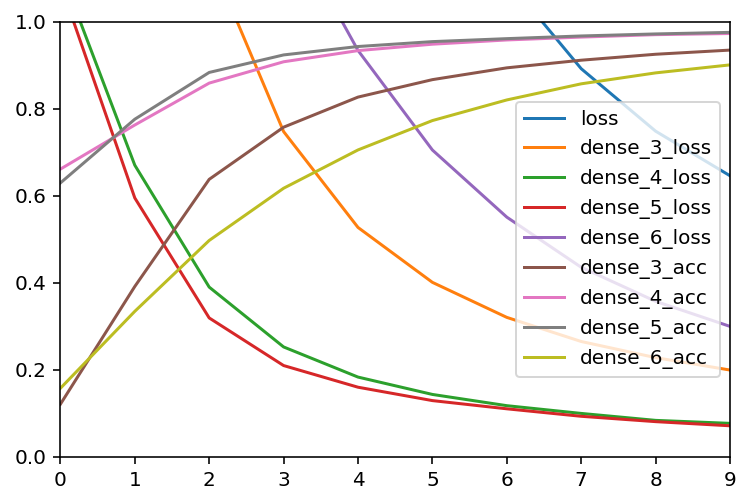

In [79]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [80]:
# Load / save

In [81]:
model.save(os.path.join("weight_save", model_name))
#model = load_model(os.path.join("weight_save", model_name))

In [16]:
# Test

In [34]:
# Build seed
idx = 42 +seq_len
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(x_test[0])):
        str_note = notes_vocab[track][np.argmax(x_test[4*track][i])]
        _duration = durations_vocab[track][np.argmax(x_test[4*track+1][i])]
        _offset = offsets_vocab[track][np.argmax(x_test[4*track+2][i])]
        _velocity = velocities_vocab[track][np.argmax(x_test[4*track+3][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [20]:
# make seq_len predictions from seed
preds = [[] for track in tracks]
x = x_test

for _ in range(seq_len*4):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 4)]
    _duration = [pred[i] for i in range(1, len(pred), 4)]
    _offset = [pred[i] for i in range(2, len(pred), 4)]
    _velocity = [pred[i] for i in range(3, len(pred), 4)]
    for track, _ in enumerate(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        cat_offset = np.zeros((len(offsets_vocab[track])))
        _offset[track] = np.argmax(_offset[track])
        cat_offset[_offset[track]] = 1
        cat_velocity = np.zeros((len(velocities_vocab[track])))
        _velocity[track] = np.argmax(_velocity[track])
        cat_velocity[_velocity[track]] = 1
        
        x[4*track] = x[4*track][1:]
        x[4*track] = list(x[4*track]) + [cat_note]
        
        x[4*track+1] = x[4*track+1][1:]
        x[4*track+1] = list(x[4*track+1]) + [cat_duration]
        
        x[4*track+2] = x[4*track+2][1:]
        x[4*track+2] = list(x[4*track+2]) + [cat_offset]
        
        x[4*track+3] = x[4*track+3][1:]
        x[4*track+3] = list(x[4*track+3]) + [cat_velocity]
        
        preds[track].append((cat_note, cat_duration, cat_offset, cat_velocity))

In [21]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        _duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        _offset = offsets_vocab[track][np.argmax(preds[track][i][2])]
        _velocity = velocities_vocab[track][np.argmax(preds[track][i][3])]
        
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [22]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [18]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()